<a href="https://colab.research.google.com/github/Seyoan/INM363_resit/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Potato Leaf Classification

Inspiration from: https://www.youtube.com/watch?v=dGtDTjYs3xc&list=PLeo1K3hjS3ut49PskOfLnE6WUoOp_2lsD&index=1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #RGB
EPOCHS = 40

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Dissertation/Code/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names # 0 = early blight, 1 = late blight, 2 = healthy

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # 68 because 2152/32 = 67.25 (rounds to 68 batches)

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) #tensor to numpy
    # 32 images in first batch, each image is (256 x 256) and RGB

(32, 256, 256, 3)
[1 0 0 0 1 0 1 0 2 1 0 1 2 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1]


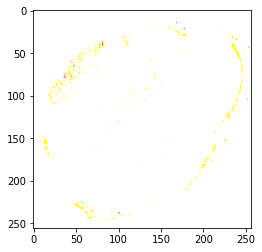

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy()) # bad image due to it being a float

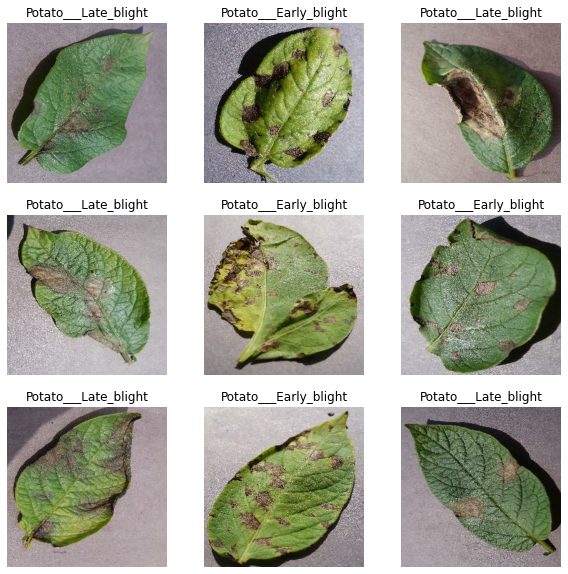

In [ ]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in dataset.take(1):
    for i in range(9): # print first 9 images
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # converted to integer, change i to 0 for 1st img
        plt.title(class_names[label_batch[i]]) # gives the label name
        plt.axis("off") #removes access

In [ ]:
# train, validation, test split

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Scale the data

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]) # if images are not 256*256, ^^ will take care of it

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## CNN model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation ='relu', input_shape=input_shape), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation ='relu'), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation ='relu'), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation ='relu'), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation ='relu'), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation ='relu'), #layers, filter_size
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation ='relu'),
    layers.Dense(n_classes, activation ='softmax'),
    
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 113s 179ms/step - loss: 0.9049 - accuracy: 0.4965 - val_loss: 0.7498 - val_accuracy: 0.6719
Epoch 2/20
54/54 [==============================] - 14s 183ms/step - loss: 0.6360 - accuracy: 0.7124 - val_loss: 0.5088 - val_accuracy: 0.7679
Epoch 3/20
54/54 [==============================] - 13s 166ms/step - loss: 0.4513 - accuracy: 0.8119 - val_loss: 0.3194 - val_accuracy: 0.8750
Epoch 4/20
54/54 [==============================] - 13s 167ms/step - loss: 0.3622 - accuracy: 0.8550 - val_loss: 0.2817 - val_accuracy: 0.8854
Epoch 5/20
54/54 [==============================] - 13s 166ms/step - loss: 0.2751 - accuracy: 0.8914 - val_loss: 0.3073 - val_accuracy: 0.9010
Epoch 6/20
54/54 [==============================] - 13s 166ms/step - loss: 0.2706 - accuracy: 0.8944 - val_loss: 0.2368 - val_accuracy: 0.9062
Epoch 7/20
54/54 [==============================] - 13s 166ms/step - loss: 0.2369 - accuracy: 0.9055 - val_loss: 0.1666 - val_accuracy: 0.932

In [ ]:
scores = model.evaluate(test_ds)
scores # [loss, accuracy]
scores_test_acc = scores[1]*100
scores_test_loss = scores[0]
print("Test Loss: ", scores_test_loss)
print("Test Accuracy: ", scores_test_acc)

8/8 [==============================] - 4s 35ms/step - loss: 0.0395 - accuracy: 0.9922
Test Loss:  0.039464980363845825
Test Accuracy:  99.21875


In [ ]:
history

In [ ]:
CNN_acc = history.history["accuracy"]
CNN_val_acc = history.history["val_accuracy"]

CNN_loss = history.history["loss"]
CNN_val_loss = history.history["val_loss"]
n = range(1,EPOCHS + 1)


# Plot the model accuracy and loss

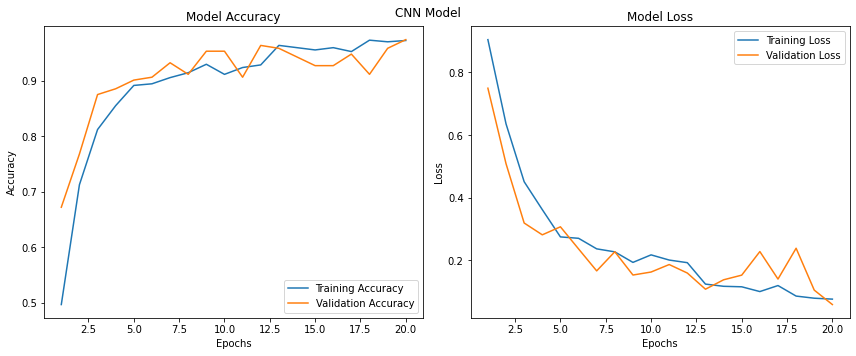

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(n,CNN_acc,label= "Training Accuracy")
plt.plot(n,CNN_val_acc,label= "Validation Accuracy")
plt.legend(loc = "best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.tight_layout()


plt.subplot(1,2,2)
plt.plot(n, CNN_loss, label='Training Loss')
plt.plot(n, CNN_val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.suptitle('CNN Model')
plt.savefig("CNN_model.png")
plt.show()

## Test how well the model is at prediciting

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # convert to numpy
  img_array = tf.expand_dims(img_array, 0) # batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


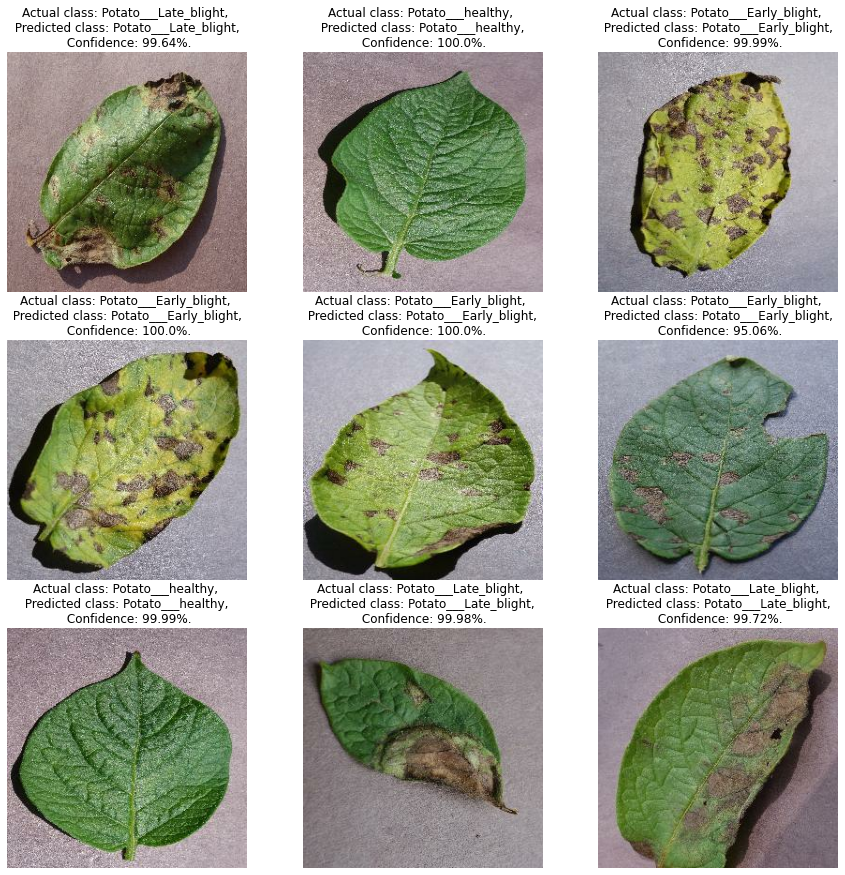

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%.")

    plt.axis("off")

plt.savefig("CNN_prediction images")

### Convert .ipynb to .html

In [ ]:
!jupyter nbconvert --to html CNN.ipynb

[NbConvertApp] Converting notebook CNN.ipynb to html
[NbConvertApp] Writing 2552609 bytes to CNN.html
